In [1]:

import numpy as np 
import matplotlib.pyplot as plt 
from time import time 
import matplotlib as mpl

import seaborn as sns
import pandas as pd 

from geomstats.geometry.hypersphere import Hypersphere

import functions


INFO: Using numpy backend


In [2]:

def MK_depth(x,u,eps,F_thetaM):
    ''' Lp depth for the uniform, aka distance to the deepest point, that is explicitly known.'''
    res = 1/(1+np.arccos(functions.Fentropic2(x,u,eps).T @ F_thetaM))
    return(res)

def MahaQuantiles(tau,data,MeanData):
    c = np.linspace(0,1,100)
    M = ((data @ MeanData).reshape(len(data),1)-c) 
    M = M*tau - M* (1*(M<=0))
    return( c[np.argmin(np.mean(M,axis=0))] )

def MahaDepth(x,data,MeanData):
    i = 0 
    tau = np.linspace(-1,1,100)[0]
    c_tau = 0 
    while (c_tau < x.T@MeanData)&(i<100):
        tau = np.linspace(0,1,100)[i]
        c_tau = MahaQuantiles(tau,data,MeanData)
        #print((c_tau < x.T@MeanData),c_tau,x.T@MeanData)
        i = i + 1 
    return(tau)

def stereoProj(x,m):
    ''' 
    - stereographic projection, x must be of shape (n,3), for n points to compute the stereo projection. n can be equal to 1. 
    - result of same shape as x.
    '''
    scp = (x @ m).reshape(len(x),1)
    return(  (x - scp*m)/(1+scp)  )

def SpatialDepth(x,data,MeanData):
    Rx = stereoProj(x.reshape(1,3),MeanData)-stereoProj(data,MeanData)
    norm = np.linalg.norm(Rx,axis=1)
    Rx = np.mean(Rx[norm>0]/norm[norm>0].reshape(np.sum(norm>0),1),axis=0)
    return(1 - np.linalg.norm(Rx))


# 0) Prequel : first dataset

<Axes3D: >

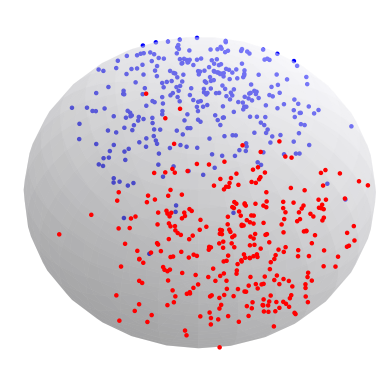

In [89]:
n_samples = 300
m1 = np.array([0,0,1])
angle = np.pi/9
ROTAT = np.array([[1,0,0],[0,np.cos(-angle),np.sin(angle)],[0,np.sin(-angle),np.cos(-angle)]])
m2 = ROTAT @ m1
data1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=10, n_samples=n_samples)
data2 = Hypersphere(dim=2).random_von_mises_fisher(mu=m2,kappa=10, n_samples=n_samples)

#) testing data 
data_test1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=10, n_samples=n_samples)
data_test2 = Hypersphere(dim=2).random_von_mises_fisher(mu=m2,kappa=10, n_samples=n_samples)

data_test = np.concatenate([data_test1,data_test2])

el = 45
az = 75
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data1 ,ax,colour="blue",sz=5)
functions.plot_3d_scatter(data2 ,ax,colour="red",sz=5)

In [96]:
MeanData1 = functions.func_GeomMedian(data1) 
MeanData2 = functions.func_GeomMedian(data2) 

# Robbins-Monro / Stochastic gradient descent 
eps = 0.01 # regularization parameter 
N_epoch = 30 
#print(N_epoch*n_samples) 
u1 = functions.Robbins_Monro_Algo_faster(Y=data1, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
u2 = functions.Robbins_Monro_Algo_faster(Y=data2, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)

F_thetaM1 = functions.Fentropic2(MeanData1,u1,eps)
F_thetaM2 = functions.Fentropic2(MeanData2,u2,eps)

MK_classif = -np.ones(data_test.shape[0])
for i,y in enumerate(data_test):
    D1 = MK_depth(y,u1,eps,F_thetaM1)
    D2 = MK_depth(y,u2,eps,F_thetaM2)
    MK_classif[i] = 1*(D2>D1)

error_rateMK = 0.5* np.mean(MK_classif[:n_samples]) + 0.5* np.mean(1-MK_classif[n_samples:])
error_rateMK 

0.06999999999999999

We can vizualise the decision frontieer, by representing our two data sets, with a grade of color depending on the depth. 

<Axes3D: >

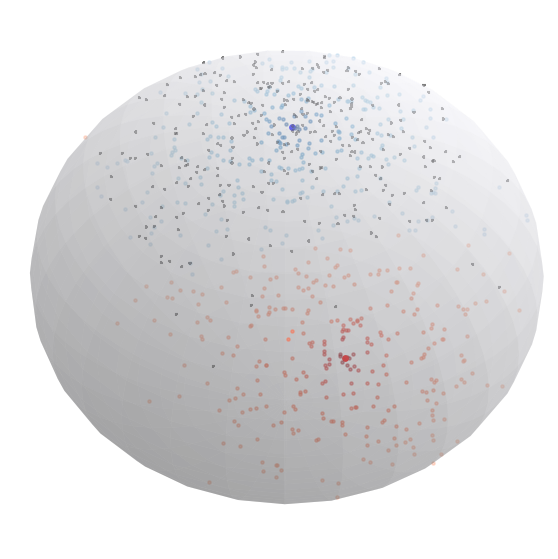

In [97]:
plt.figure(figsize=(7,7))
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3) 
functions.plot_3d_scatter(MeanData1.reshape(1,3),ax,colour="blue",sz=15,alpha=1)
functions.plot_3d_scatter(MeanData2.reshape(1,3),ax,colour="red",sz=15,alpha=1)
# regularized errors for a single choice of parameters (s,eps)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap1.set_array([])
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2.set_array([])

for i in range(data_test.shape[0]):
    x = data_test[i]
    depth1 = MK_depth(x,u1,eps,F_thetaM1) 
    depth2 = MK_depth(x,u2,eps,F_thetaM2)
    df = x.reshape(1,3) 
    if (depth1>=depth2):
        functions.plot_3d_scatter(df ,ax,colour=cmap1.to_rgba(depth1),sz=5,alpha=0.5)
    else: 
        functions.plot_3d_scatter(df ,ax,colour=cmap2.to_rgba(depth2),sz=5,alpha=0.5)


functions.plot_3d_scatter(data1 ,ax,colour='black',marker='+',sz=5,alpha=0.5)

Other notions of quantiles :

In [98]:
Maha_classif = -np.ones(data_test.shape[0])
for i,y in enumerate(data_test):
    D1 = MahaDepth(y,data1,MeanData1) 
    D2 = MahaDepth(y,data2,MeanData2)
    Maha_classif[i] = 1*(D2>D1)

error_rateMaha = 0.5* np.mean(Maha_classif[:n_samples]) + 0.5* np.mean(1-Maha_classif[n_samples:])
error_rateMaha 

0.06833333333333333

In [99]:
Spatial_classif = -np.ones(data_test.shape[0])
for i,y in enumerate(data_test):
    D1 = SpatialDepth(y,data1,MeanData1) 
    D2 = SpatialDepth(y,data2,MeanData2)
    Spatial_classif[i] = 1*(D2>D1)

error_rateSpatial = 0.5* np.mean(Spatial_classif[:n_samples]) + 0.5* np.mean(1-Spatial_classif[n_samples:])
error_rateSpatial

0.06666666666666668

<Axes3D: >

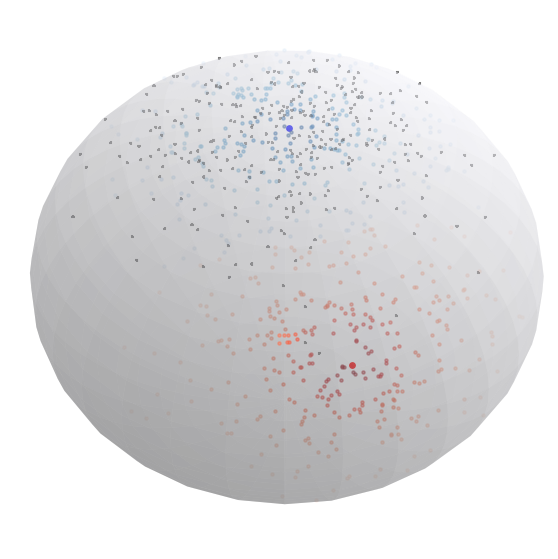

In [41]:
plt.figure(figsize=(7,7))
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3) 
functions.plot_3d_scatter(MeanData1.reshape(1,3),ax,colour="blue",sz=15,alpha=1)
functions.plot_3d_scatter(MeanData2.reshape(1,3),ax,colour="red",sz=15,alpha=1)
# regularized errors for a single choice of parameters (s,eps)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap1 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap1.set_array([])
cmap2 = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Reds)
cmap2.set_array([])

for i in range(data_test.shape[0]):
    x = data_test[i]
    depth1 = SpatialDepth(x,data1,MeanData1) 
    depth2 = SpatialDepth(x,data2,MeanData2)
    df = x.reshape(1,3) 
    if (depth1>=depth2):
        functions.plot_3d_scatter(df ,ax,colour=cmap1.to_rgba(depth1),sz=5,alpha=0.5)
    else: 
        functions.plot_3d_scatter(df ,ax,colour=cmap2.to_rgba(depth2),sz=5,alpha=0.5)

functions.plot_3d_scatter(data1 ,ax,colour='black',marker='+',sz=5,alpha=0.5)

In [100]:
def sample_vMF(n_samples):
    m1 = np.array([0,0,1])
    angle = np.pi/9
    ROTAT = np.array([[1,0,0],[0,np.cos(-angle),np.sin(angle)],[0,np.sin(-angle),np.cos(-angle)]])
    m2 = ROTAT @ m1
    data1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=10, n_samples=n_samples)
    data2 = Hypersphere(dim=2).random_von_mises_fisher(mu=m2,kappa=10, n_samples=n_samples)

    return(data1,data2)

## What if we change the regularization parameter $\epsilon$?

In [103]:
c = 0 
N = 10 
range_eps = [0.0001,0.001,0.01,0.1,0.2,0.5] 
errorsMK_eps = -np.ones((N,len(range_eps))) 
for eps in range_eps:
    for rep in range(N):
        n_samples = 400 
        # 1) training data 
        data1,data2 = sample_vMF(n_samples)
        #) testing data 
        data_test1,data_test2 = sample_vMF(n_samples)
        data_test = np.concatenate([data_test1,data_test2])

        MeanData1 = functions.func_GeomMedian(data1) 
        MeanData2 = functions.func_GeomMedian(data2) 

        # Entropic Optimal Transport
        N_epoch = 30
        u1 = functions.Robbins_Monro_Algo_faster(Y=data1, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
        u2 = functions.Robbins_Monro_Algo_faster(Y=data2, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
        F_thetaM1 = functions.Fentropic2(MeanData1,u1,eps)
        F_thetaM2 = functions.Fentropic2(MeanData2,u2,eps)
        MK_classif = -np.ones(data_test.shape[0])

        for i,y in enumerate(data_test):
            D1 = MK_depth(y,u1,eps,F_thetaM1)
            D2 = MK_depth(y,u2,eps,F_thetaM2)
            MK_classif[i] = 1*(D2>D1)
        error_rateMK = 0.5* np.sum(MK_classif[:n_samples])/n_samples + 0.5* np.sum(1-MK_classif[n_samples:])/n_samples
        errorsMK_eps[rep,c] = error_rateMK
    print(c)
    c = c +1

0
1
2
3
4
5


/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


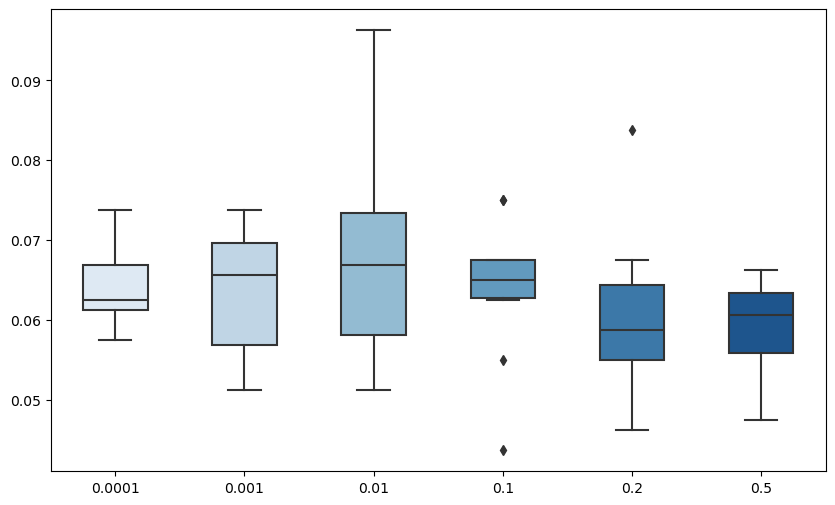

In [104]:
a = pd.DataFrame({ 'group' : np.repeat('{}'.format(range_eps[0]),N), 'value': errorsMK_eps[:,0] })
for i in range(1,len(range_eps)):
    eps = range_eps[i]
    b = pd.DataFrame({ 'group' : np.repeat('{}'.format(eps),N), 'value': errorsMK_eps[:,i] })
    a = pd.concat([a,b])

plt.figure(figsize=(10,6))
# Usual boxplot
bp = sns.boxplot(x='group', y='value', data=a ,palette="Blues",width=0.5)
bp.set(xlabel=None)
bp.set(ylabel=None)

plt.show()

# Monte-Carlo experiments

# 1) von Mises-Fischer 

<Axes3D: >

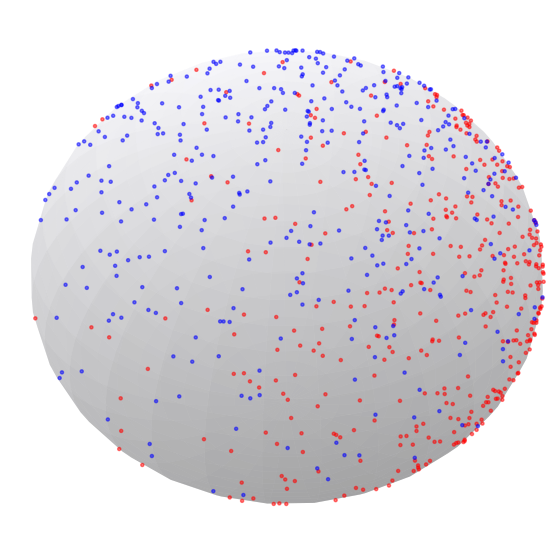

In [168]:
n_samples = 400
m1 = np.array([0,0,1])
data1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=3, n_samples=n_samples)
angle = np.pi/3 
ROTAT = np.array([[1,0,0],[0,np.cos(-angle),np.sin(angle)],[0,np.sin(-angle),np.cos(-angle)]])
data2 = np.zeros((n_samples,3))
for i in range(n_samples):
    data2[i] = ROTAT @ data1[i]

#) testing data 
data_test1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=3, n_samples=n_samples)
data_test2 = np.zeros((n_samples,3))
for i in range(n_samples):
    data_test2[i] = ROTAT @ data_test1[i]
data_test = np.concatenate([data_test1,data_test2])

plt.figure(figsize=(7,7))
el = 45
az = 30
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data1 ,ax,colour="blue",sz=5,alpha=0.5)
functions.plot_3d_scatter(data2 ,ax,colour="red",sz=5,alpha=0.5)

In [163]:
N = 20
errorsMK = -np.ones(N)
errorsMaha = -np.ones(N)
errorsSpatial = -np.ones(N)

for rep in range(N): 
    ######## SAMPLE DATA 
    n_samples = 400 
    # 1) training data 
    m1 = np.array([0,0,1])
    angle = np.pi/3 
    ROTAT = np.array([[1,0,0],[0,np.cos(-angle),np.sin(angle)],[0,np.sin(-angle),np.cos(-angle)]])
    data1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=3, n_samples=n_samples)
    data2 = np.zeros((n_samples,3))
    for i in range(n_samples):
        data2[i] = ROTAT @ data1[i]
    #) testing data 
    data_test1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=3, n_samples=n_samples)
    data_test2 = np.zeros((n_samples,3))
    for i in range(n_samples):
        data_test2[i] = ROTAT @ data_test1[i]
    data_test = np.concatenate([data_test1,data_test2])
    ########

    MeanData1 = functions.func_GeomMedian(data1) 
    MeanData2 = functions.func_GeomMedian(data2)

    ######### Entropic Optimal Transport
    eps = 0.1  # regularization parameter 
    N_epoch = 30

    u1 = functions.Robbins_Monro_Algo_faster(Y=data1, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    u2 = functions.Robbins_Monro_Algo_faster(Y=data2, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    F_thetaM1 = functions.Fentropic2(MeanData1,u1,eps)
    F_thetaM2 = functions.Fentropic2(MeanData2,u2,eps)
    MK_classif = -np.ones(data_test.shape[0])

    for i,y in enumerate(data_test):
        D1 = MK_depth(y,u1,eps,F_thetaM1)
        D2 = MK_depth(y,u2,eps,F_thetaM2)
        MK_classif[i] = 1*(D2>D1)
    error_rateMK = 0.5* np.sum(MK_classif[:n_samples])/n_samples + 0.5* np.sum(1-MK_classif[n_samples:])/n_samples
    errorsMK[rep] = error_rateMK

    ######### Mahalanobis quantiles
    Maha_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = MahaDepth(y,data1,MeanData1) 
        D2 = MahaDepth(y,data2,MeanData2)
        Maha_classif[i] = 1*(D2>D1)
    error_rateMaha = 0.5* np.sum(Maha_classif[:n_samples])/n_samples + 0.5* np.sum(1-Maha_classif[n_samples:])/n_samples
    errorsMaha[rep] = error_rateMaha 

    ######### Spatial quantiles
    Spatial_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = SpatialDepth(y,data1,MeanData1) 
        D2 = SpatialDepth(y,data2,MeanData2)
        Spatial_classif[i] = 1*(D2>D1)
    error_rateSpatial = 0.5* np.sum(Spatial_classif[:n_samples])/n_samples + 0.5* np.sum(1-Spatial_classif[n_samples:])/n_samples
    errorsSpatial[rep] = error_rateSpatial
    print(rep)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


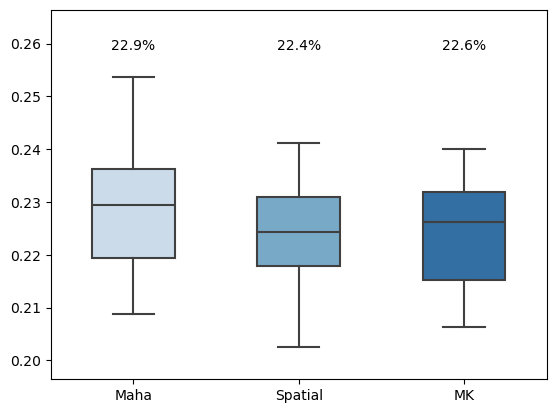

In [164]:
a = pd.DataFrame({ 'group' : np.repeat('Maha',N), 'value': errorsMaha })
b = pd.DataFrame({ 'group' : np.repeat('Spatial',N), 'value': errorsSpatial })
c = pd.DataFrame({ 'group' : np.repeat('MK',N), 'value': errorsMK })
df = pd.concat([a,b,c])#a.append(b).append(c)

# Usual boxplot 
bp = sns.boxplot(x='group', y='value', data=df,palette="Blues",width=0.5)
bp.set(xlabel=None)
bp.set(ylabel=None)

medians = np.array([np.median(errorsMaha),np.median(errorsSpatial),np.median(errorsMK)])
vertical_offset = np.max(df['value']) *(1.02) # offset from median for display

for xtick in bp.get_xticks():
    bp.text(xtick,vertical_offset,'{}%'.format(np.round(100*medians[xtick],1)),horizontalalignment='center',color='black')

plt.ylim(np.min(df['value']) *(0.97), np.max(df['value']) *(1.05))
plt.show()

# 2) Tangent von-Mises Fischer

We sample $X$ as follows.
Let $m_1 = (0,0,1)^T$, denote $V \sim \text{Beta}(2,8)$, $Z = 2V-1$, and $S$ is a von-Mises Fisher distribution in $\mathbb{R^2}$, that is on the circle, with location $(1,0)^T$, concentration $\kappa = 5$, $Z$ and $S$ independant. Then, 
$$
X = Z m_1 + \sqrt{1-Z^2} (S,0^T),
$$
where $(S,0^T) \in\mathbb{R^3}$.

In [170]:
from scipy.stats import vonmises_fisher # One-dimensional vMF on the circle

def sampleTangentvMF(n_samples):
    m1 = np.array([0,0,1])
    angle = -np.pi/3
    ROTAT = np.array([[1,0,0],[0,np.cos(angle),-np.sin(angle)],[0,np.sin(angle),np.cos(angle)]])

    V = np.random.beta(2,8,size=n_samples)
    Z = 2*V -1 
    S = np.zeros((n_samples,3))
    S[:,0:2] = vonmises_fisher(mu=np.array([1,0]),kappa=5).rvs(n_samples)
    data1 = Z.reshape(n_samples,1)*m1 + np.sqrt(1-Z**2).reshape(n_samples,1)*S

    data2 = np.zeros((n_samples,3))
    for i in range(n_samples):
        data2[i] = ROTAT @ data1[i]
    return(data1,data2)


In [171]:
n_samples = 400
data1,data2 = sampleTangentvMF(n_samples)

#) testing data 
data_test1,data_test2 = sampleTangentvMF(n_samples)
data_test = np.concatenate([data_test1,data_test2])

<Axes3D: >

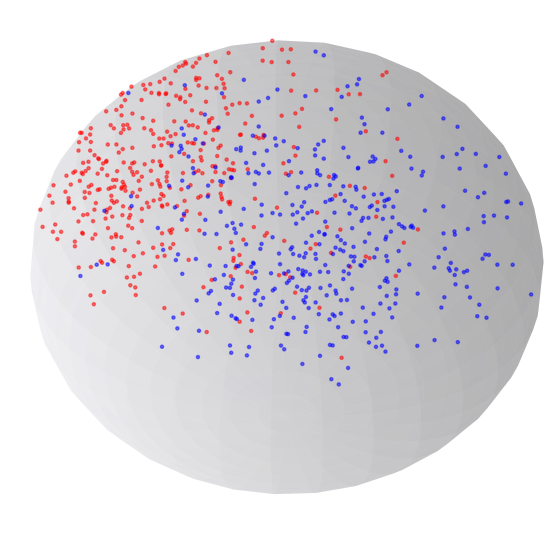

In [178]:
plt.figure(figsize=(7,7))
el = -45
az = -10
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data1 ,ax,colour="blue",sz=5,alpha=0.5)
functions.plot_3d_scatter(data2 ,ax,colour="red",sz=5,alpha=0.5)

In [159]:
N = 20
errorsMK = -np.ones(N)
errorsMaha = -np.ones(N)
errorsSpatial = -np.ones(N)

for rep in range(N):
    n_samples = 400 
    # 1) training data 
    m1 = np.array([0,0,1])
    data1,data2 = sampleTangentvMF(n_samples)
    #) testing data 
    data_test1,data_test2 = sampleTangentvMF(n_samples)
    data_test = np.concatenate([data_test1,data_test2])

    MeanData1 = functions.func_GeomMedian(data1) 
    MeanData2 = functions.func_GeomMedian(data2)

    # Entropic Optimal Transport
    eps = 0.1 # regularization parameter 
    N_epoch = 30
    u1 = functions.Robbins_Monro_Algo_faster(Y=data1, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    u2 = functions.Robbins_Monro_Algo_faster(Y=data2, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    F_thetaM1 = functions.Fentropic2(MeanData1,u1,eps)
    F_thetaM2 = functions.Fentropic2(MeanData2,u2,eps)
    MK_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = MK_depth(y,u1,eps,F_thetaM1)
        D2 = MK_depth(y,u2,eps,F_thetaM2)
        MK_classif[i] = 1*(D2>D1)
    error_rateMK = 0.5* np.sum(MK_classif[:n_samples])/n_samples + 0.5* np.sum(1-MK_classif[n_samples:])/n_samples
    errorsMK[rep] = error_rateMK

    # Mahalanobis quantiles
    Maha_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = MahaDepth(y,data1,MeanData1) 
        D2 = MahaDepth(y,data2,MeanData2)
        Maha_classif[i] = 1*(D2>D1)
    error_rateMaha = 0.5* np.sum(Maha_classif[:n_samples])/n_samples + 0.5* np.sum(1-Maha_classif[n_samples:])/n_samples
    errorsMaha[rep] = error_rateMaha 

    # Spatial quantiles
    Spatial_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = SpatialDepth(y,data1,MeanData1) 
        D2 = SpatialDepth(y,data2,MeanData2)
        Spatial_classif[i] = 1*(D2>D1)
    error_rateSpatial = 0.5* np.sum(Spatial_classif[:n_samples])/n_samples + 0.5* np.sum(1-Spatial_classif[n_samples:])/n_samples
    errorsSpatial[rep] = error_rateSpatial
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


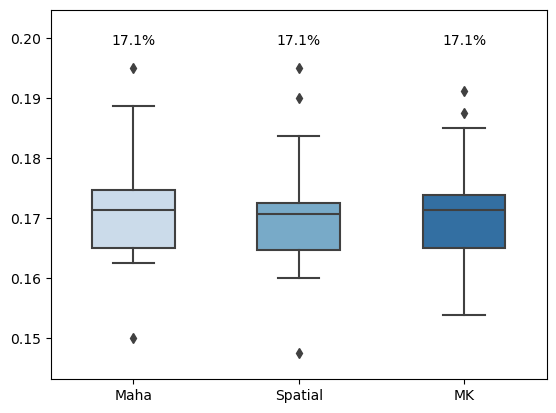

In [160]:
a = pd.DataFrame({ 'group' : np.repeat('Maha',N), 'value': errorsMaha })
b = pd.DataFrame({ 'group' : np.repeat('Spatial',N), 'value': errorsSpatial })
c = pd.DataFrame({ 'group' : np.repeat('MK',N), 'value': errorsMK })
df = pd.concat([a,b,c])#a.append(b).append(c)

# Usual boxplot
bp = sns.boxplot(x='group', y='value', data=df,palette="Blues",width=0.5)
bp.set(xlabel=None)
bp.set(ylabel=None)

medians = np.array([np.median(errorsMaha),np.median(errorsSpatial),np.median(errorsMK)])
vertical_offset = np.max(df['value']) *(1.02) # offset from median for display

for xtick in bp.get_xticks():
    bp.text(xtick,vertical_offset,'{}%'.format(np.round(100*medians[xtick],1)),horizontalalignment='center',color='black')

plt.ylim(np.min(df['value']) *(0.97), np.max(df['value']) *(1.05))
plt.show()

# Mixtures 

In [192]:

def sample_mixtures(n_samples):

    dataA = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.2,-0.5,np.sqrt(1-0.2**2-0.5**2)]),kappa=50, n_samples=int(n_samples*0.2))
    dataB = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.2,0.5,np.sqrt(1-0.2**2-0.5**2)]),kappa=50, n_samples=int(n_samples*0.2))
    dataC = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0.7,0,np.sqrt(1-0.7**2)]),kappa=20, n_samples=n_samples-int(n_samples*0.2)*2)
    data1 = np.concatenate([dataA,dataB,dataC])

    data2 = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0,1]),kappa=50, n_samples=n_samples)
    return(data1,data2)


n_samples = 400
data1,data2 = sample_mixtures(n_samples)

<Axes3D: >

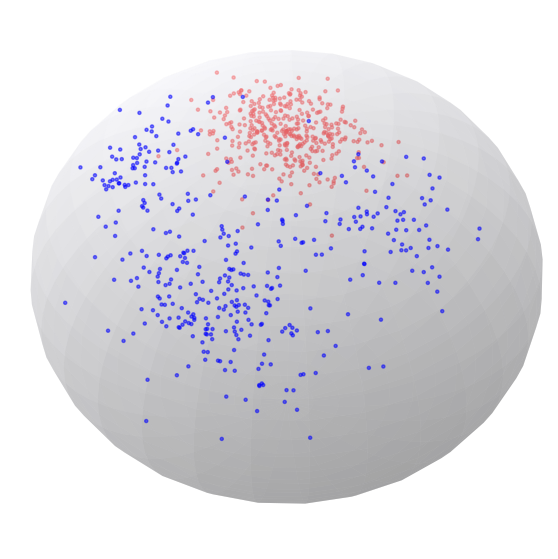

In [193]:
plt.figure(figsize=(7,7))
el = 45
az = 20
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data1 ,ax,colour="blue",sz=5,alpha=0.5)
functions.plot_3d_scatter(data2 ,ax,colour="red",sz=5,alpha=0.5)

In [146]:
N = 20
errorsMK = -np.ones(N)
errorsMaha = -np.ones(N)
errorsSpatial = -np.ones(N)

for rep in range(N):
    n_samples = 400 
    # 1) training data 
    data1,data2 = sample_mixtures(n_samples)
    #) testing data 
    data_test1,data_test2 = sample_mixtures(n_samples)
    data_test = np.concatenate([data_test1,data_test2])

    MeanData1 = functions.func_GeomMedian(data1) 
    MeanData2 = functions.func_GeomMedian(data2)

    # Entropic Optimal Transport
    eps = 0.1 # regularization parameter 
    N_epoch = 30
    u1 = functions.Robbins_Monro_Algo_faster(Y=data1, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    u2 = functions.Robbins_Monro_Algo_faster(Y=data2, eps=eps, gamma= 1, c = 0.75, epoch = N_epoch,l_max=30)
    F_thetaM1 = functions.Fentropic2(MeanData1,u1,eps)
    F_thetaM2 = functions.Fentropic2(MeanData2,u2,eps)
    MK_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = MK_depth(y,u1,eps,F_thetaM1)
        D2 = MK_depth(y,u2,eps,F_thetaM2)
        MK_classif[i] = 1*(D2>D1)
    error_rateMK = 0.5* np.sum(MK_classif[:n_samples])/n_samples + 0.5* np.sum(1-MK_classif[n_samples:])/n_samples
    errorsMK[rep] = error_rateMK

    # Mahalanobis quantiles
    Maha_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = MahaDepth(y,data1,MeanData1) 
        D2 = MahaDepth(y,data2,MeanData2)
        Maha_classif[i] = 1*(D2>D1)
    error_rateMaha = 0.5* np.sum(Maha_classif[:n_samples])/n_samples + 0.5* np.sum(1-Maha_classif[n_samples:])/n_samples
    errorsMaha[rep] = error_rateMaha 

    # Spatial quantiles
    Spatial_classif = -np.ones(data_test.shape[0])
    for i,y in enumerate(data_test):
        D1 = SpatialDepth(y,data1,MeanData1) 
        D2 = SpatialDepth(y,data2,MeanData2)
        Spatial_classif[i] = 1*(D2>D1)
    error_rateSpatial = 0.5* np.sum(Spatial_classif[:n_samples])/n_samples + 0.5* np.sum(1-Spatial_classif[n_samples:])/n_samples
    errorsSpatial[rep] = error_rateSpatial
    print(rep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/glthurin/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


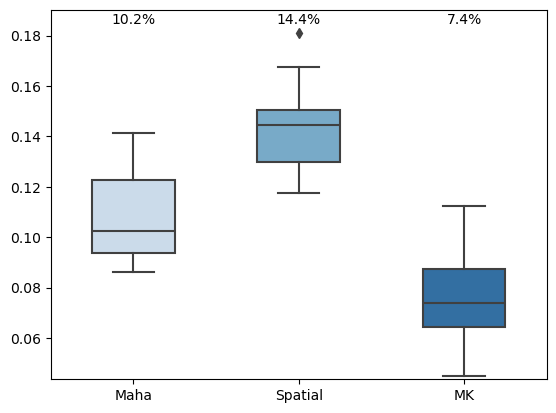

In [148]:
a = pd.DataFrame({ 'group' : np.repeat('Maha',N), 'value': errorsMaha })
b = pd.DataFrame({ 'group' : np.repeat('Spatial',N), 'value': errorsSpatial })
c = pd.DataFrame({ 'group' : np.repeat('MK',N), 'value': errorsMK })
df = pd.concat([a,b,c])#a.append(b).append(c)

# Usual boxplot
bp = sns.boxplot(x='group', y='value', data=df,palette="Blues",width=0.5)
bp.set(xlabel=None)
bp.set(ylabel=None)

medians = np.array([np.median(errorsMaha),np.median(errorsSpatial),np.median(errorsMK)])
vertical_offset = np.max(df['value']) *(1.02) # offset from median for display

for xtick in bp.get_xticks():
    bp.text(xtick,vertical_offset,'{}%'.format(np.round(100*medians[xtick],1)),horizontalalignment='center',color='black')

plt.ylim(np.min(df['value']) *(0.97), np.max(df['value']) *(1.05))
plt.show()